<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

Импортирование библиотек:

In [1]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import time
import copy
import pickle

from matplotlib import rcParams
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (15,4)

from torchsummary import summary

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>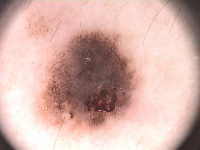</td><td>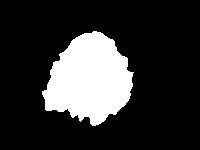</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []

root = 'PH2Dataset'

# for root, dirs, files in os.walk('/kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset'):
for root, dirs, files in os.walk('PH2 Dataset images'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

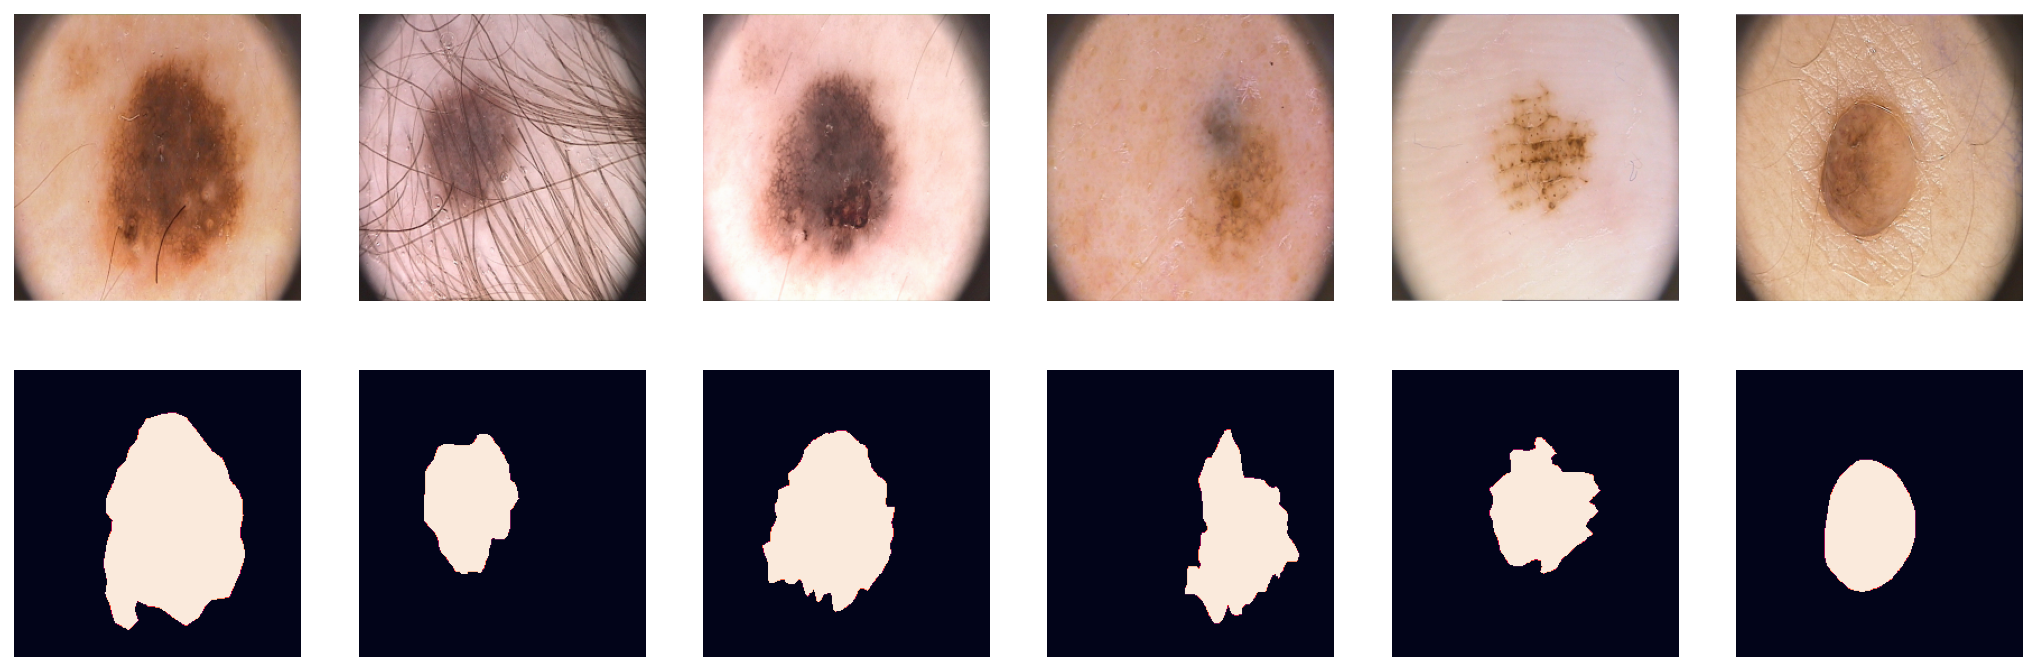

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
batch_size = 2
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

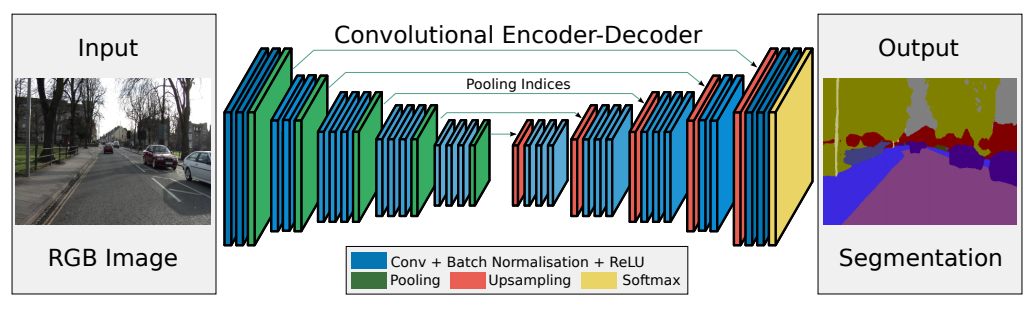

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Encoder часть выполнена по аналогии с vgg16:

In [11]:
vgg16 = models.vgg16()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Определим SegNet:**

In [12]:
class SegNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )

    
    def forward(self, x):
#         x.to(device)
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        dim_3 = e2.size()
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3, output_size=dim_3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation
        return d3

In [13]:
from torchsummary import summary
seg_net = SegNet().to(device)
summary(seg_net, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

### Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou

### Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_pred, y_real):
    # loss = nn.BCEWithLogitsLoss()
    loss = - y_pred * y_real + torch.log(1 + torch.exp(y_pred))
    return loss.mean()

### Тренировка [1 балл]

Функция для обучения, представленная в задании

In [16]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    k = 0
    for epoch in range(epochs):
        tic = time.time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            k += 1
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
#             m = nn.Sigmoid()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time.time()
        print(f'loss: {avg_loss}, time: {toc-tic}')

        # show intermediate results
        model.eval()  # testing mode
        with torch.set_grad_enabled(False):
            Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [17]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    with torch.no_grad():
        scores = 0
        m = nn.Sigmoid()
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_pred = m(model(X_batch)) > 0.5
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

        return scores / len(data)

**Функция для обучения, выбырающая лучшую модель на основе IOU на валидационной выборке:**

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=2, batch_size=2):
    
    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }
    dataset_sizes = {'train': len(tr), 'val': len(val)}
    
    history = {
        'loss_tr': [],
        'loss_val': [],
        'iou_tr': [],
        'iou_val': []
    }
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 20000
    best_iou = 0
    
    for epoch in range(num_epochs):
        show_key = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            avg_loss_tr = 0
            avg_loss_val = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase == 'train':
                    avg_loss_tr += loss  # / len(data_tr)
                else:
                    avg_loss_val += loss # / len(data_val)
#                 running_loss += loss.item() * inputs.size(0)

                if phase == 'val' and show_key == 0:
                    show_key = 1
                    # show intermediate results
                    model.eval()  # testing mode
                    with torch.set_grad_enabled(False):
                        Y_hat = model(inputs.to(device)).detach().to('cpu') # detach and put into cpu

                    # Visualize tools
                    clear_output(wait=True)
                    for k in range(batch_size):
                        plt.subplot(2, 6, k+1)
                        plt.imshow(np.rollaxis(inputs[k].detach().to('cpu').numpy(), 0, 3), cmap='gray')
                        plt.title('Real')
                        plt.axis('off')

                        plt.subplot(2, 6, k+7)
                        plt.imshow(Y_hat[k, 0], cmap='gray')
                        plt.title('Output')
                        plt.axis('off')
                    plt.show()
            
#             if phase == 'train' and scheduler:
#                 scheduler.step()
            
            if phase == 'train':
                history['loss_tr'].append(avg_loss_tr / len(data_tr))
                iou_tr = score_model(model, iou_pytorch, data_tr)
                history['iou_tr'].append(iou_tr)
            else:
                history['loss_val'].append(avg_loss_val / len(data_val))
                curr_loss = avg_loss_val / len(data_val)
                print(f'Loss Val: {curr_loss:.4f}')
                iou_val = score_model(model, iou_pytorch, data_val)
                history['iou_val'].append(iou_val)

            # deep copy the model
            if phase == 'val' and iou_val > best_iou:
                best_iou = iou_val
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    with torch.no_grad():
        scores = 0
        m = nn.Sigmoid()
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_pred = m(model(X_batch)) > 0.5
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

        return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


**Процесс обучения всех моделей был выполнен на kaggle при 100 эпохах:**

In [21]:
# model = SegNet().to(device)
# max_epochs = 2
# optimizer = optim.Adam(model.parameters())
# best_seg_net, history = train_model(model, 
#                                     data_tr, data_val, 
#                                     bce_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

Функция для сохранения модели и истории:

In [22]:
def save_model(model, history, name:str):
    torch.save(model.state_dict(), name)
    with open(name + '_history.pkl', 'wb') as f:
        pickle.dump(history, f)

In [23]:
# save_model(model, history, 'segnet_bce')

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [24]:
def dice_loss(y_pred, y_real):
    SMOOTH = 1e-6
    y_pred = y_pred.sigmoid()
    num = 2 * y_real * y_pred
    den = y_real + y_pred
    res = 1 - 1 / (256 * 256) * ((num + SMOOTH) / (den + SMOOTH)).sum(dim=(1,2,3))
    return res.mean()

Проводим тестирование:

In [25]:
# model_dice = SegNet().to(device)

# max_epochs = 100
# optimizer = optim.Adam(model_dice.parameters())
# best_seg_net, history = train_model(model_dice, 
#                                     data_tr, data_val, 
#                                     dice_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

In [26]:
# save_model(model_dice, history, 'segnet_dice_nosig')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [27]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2, alpha=1):
    BCE = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    y_pred =  torch.clamp(y_pred, eps, 1.0)
    loss = alpha * (1 - torch.exp(-BCE)) ** gamma * BCE
    return loss.mean()

In [28]:
# model_focal = SegNet().to(device)

# max_epochs = 100
# optimizer = optim.Adam(model_focal.parameters())
# best_seg_net, history = train_model(model_focal, 
#                                     data_tr, data_val, 
#                                     focal_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

In [29]:
# save_model(model_focal, history, 'segnet_focal')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

See a useful [repo](https://github.com/JunMa11/SegLoss) with losses for image segmentation

![seglosses](https://raw.githubusercontent.com/JunMa11/SegLoss/master/test/LossOverview.PNG)

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме того провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.


**Имплементация Hausdorff loss ([статья](https://arxiv.org/pdf/1904.10030.pdf)):**

In [30]:
from scipy.ndimage.morphology import distance_transform_edt as edt


class HausdorffDTLoss(nn.Module):

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

#         pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.detach().cpu().numpy())).float().to(device)
        target_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy())).float().to(device)
        
        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error * distance
        loss = dt_field.mean()

        return loss

In [31]:
def h_loss(y_pred, y_real):
    hausdorfdt_loss = HausdorffDTLoss()
    return hausdorfdt_loss(y_pred, y_real)

In [32]:
# model_h = SegNet().to(device)

# max_epochs = 10
# optimizer = optim.Adam(model_h.parameters())
# best_seg_net, history = train_model(model_h, 
#                                     data_tr, data_val, 
#                                     h_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

**Assymetric loss ([статья](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8573779)):**

In [33]:
def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp


def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn

In [34]:
class AsymLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=0.5,
                 square=True):

        super(AsymLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth
        self.beta = 1.5

    def forward(self, y, x, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)# shape: (batch size, class num)
        weight = (self.beta**2)/(1+self.beta**2)
        asym = (tp + self.smooth) / (tp + weight*fn + (1-weight)*fp + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                asym = asym[1:]
            else:
                asym = asym[:, 1:]
        asym = asym.mean()

        return -asym

In [35]:
def asym_loss(y_pred, y_real):
    loss = AsymLoss()
    return loss(y_pred, y_real)

# model_asym = SegNet().to(device)

# max_epochs = 100
# optimizer = optim.Adam(model_asym.parameters())
# best_seg_net, history = train_model(model_asym, 
#                                     data_tr, data_val, 
#                                     asym_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

In [36]:
# save_model(model_asym, history, 'segnet_asym')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

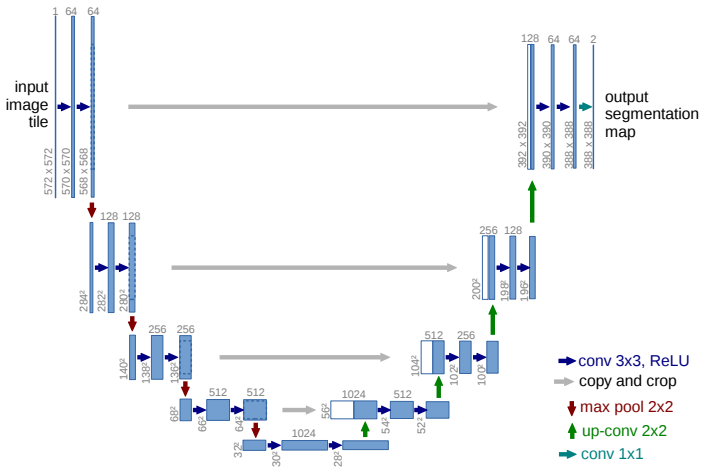

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.
* [DL School lection](https://www.youtube.com/watch?v=yEuIV5FsRMs&t=0s)

In [37]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [38]:
# unet_model = UNet(3, 1).to(device)

# max_epochs = 40
# optimizer = optim.Adam(unet_model.parameters())
# best_seg_net, history = train_model(unet_model, 
#                                     data_tr, data_val, 
#                                     h_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

In [39]:
# save_model(unet_model, history, 'unet_h_40')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [40]:
# unet2_model = UNet(bilinear=False).to(device)

# max_epochs = 100
# optimizer = optim.Adam(unet2_model.parameters())
# best_seg_net, history = train_model(unet2_model, 
#                                     data_tr, data_val, 
#                                     asym_loss, optimizer, scheduler=None, 
#                                     num_epochs=max_epochs, batch_size=batch_size);

In [41]:
# save_model(unet2_model, history, 'unet2_asym')

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

#### Функции для удобства оценки моделей:

In [67]:
def test_iou(model_class, model_name: str):
    sns.set(rc={'figure.figsize':(10,3)})
    if 'unet2' in model_name:
        model = model_class(bilinear=False).to(device)
    else:
        model = model_class().to(device)
    model.load_state_dict(torch.load(model_name))
    iou = score_model(model, iou_pytorch, data_ts)
    print(f'model: {model_name};\tIOU score on testset: {round(iou, 3)}')
    


In [43]:
def plot_iou(models):
    sns.set(rc={'figure.figsize':(12,8)})
    for model in models:
        with open(model + '_history.pkl', 'rb') as f:
            history = pickle.load(f)
        plt.plot(history['iou_val'], label=model)
    plt.xlabel('epochs')
    plt.title('IOU на валидационной выборке')
    plt.legend()

In [94]:
def plot_models(models):
    sns.set(rc={'figure.figsize':(16,5)})
    for i in range(len(models)):
        plt.subplot(1, len(models), i+1)

        with open(models[i] + '_history.pkl', 'rb') as f:
            history = pickle.load(f)
        plt.plot(history['loss_tr'], label='Train Loss')
        plt.plot(history['loss_val'], label='Val Loss');
        plt.plot(history['iou_tr'], label='Train IOU')
        plt.plot(history['iou_val'], label='Val IOU')
        plt.legend()
        plt.xlabel('epochs')
        plt.title(models[i])

In [116]:
segnet_models = ['segnet_bce', 'segnet_dice', 'segnet_focal']
unet_models = ['unet_bce', 'unet_dice', 'unet_focal', 'unet_asym', 'unet_h_40']
unet2_models = ['unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_asym']

### Посмотрим на SegNet модели:

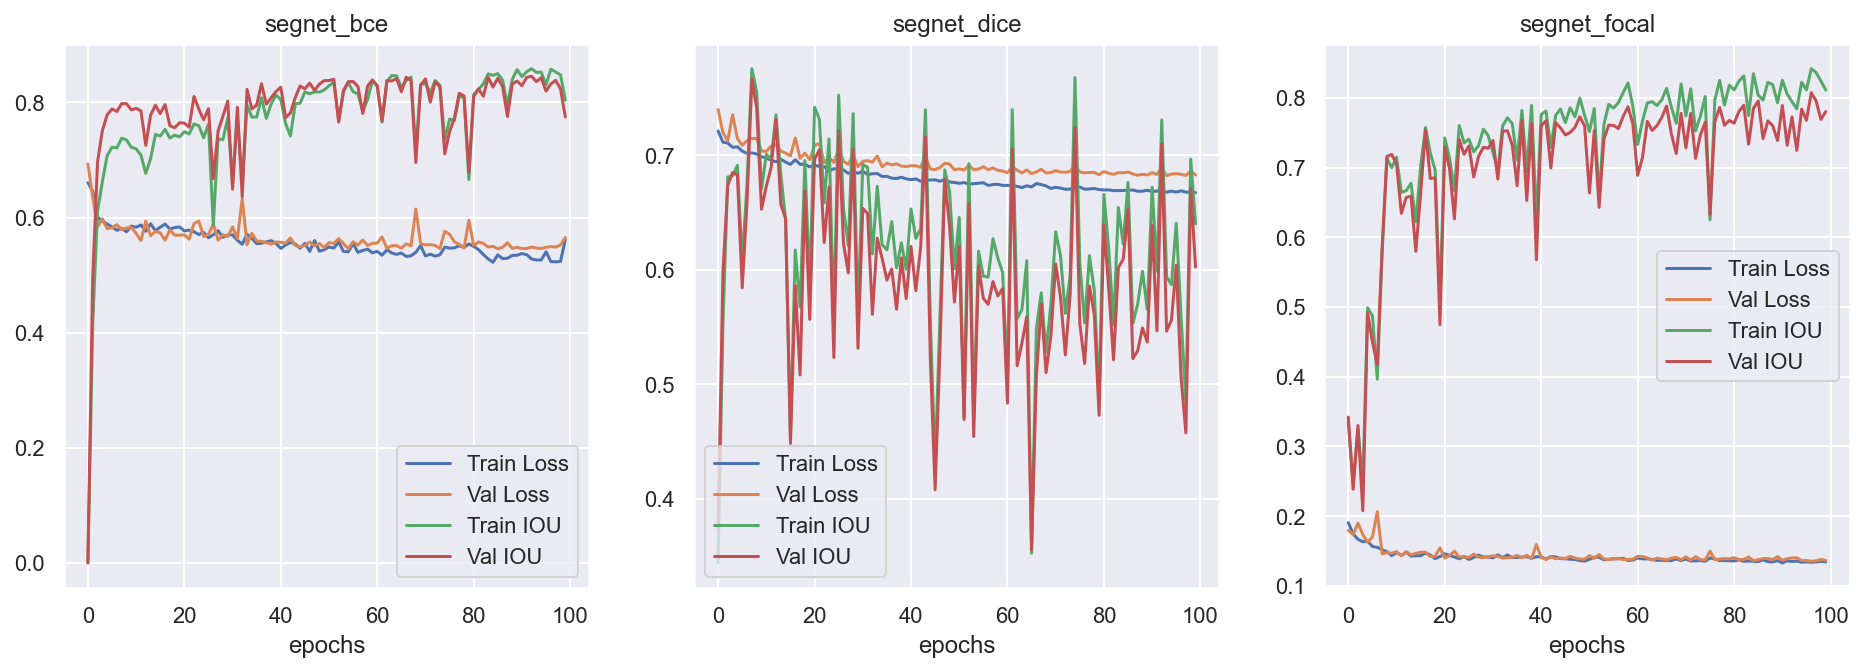

In [96]:
plot_models(segnet_models)

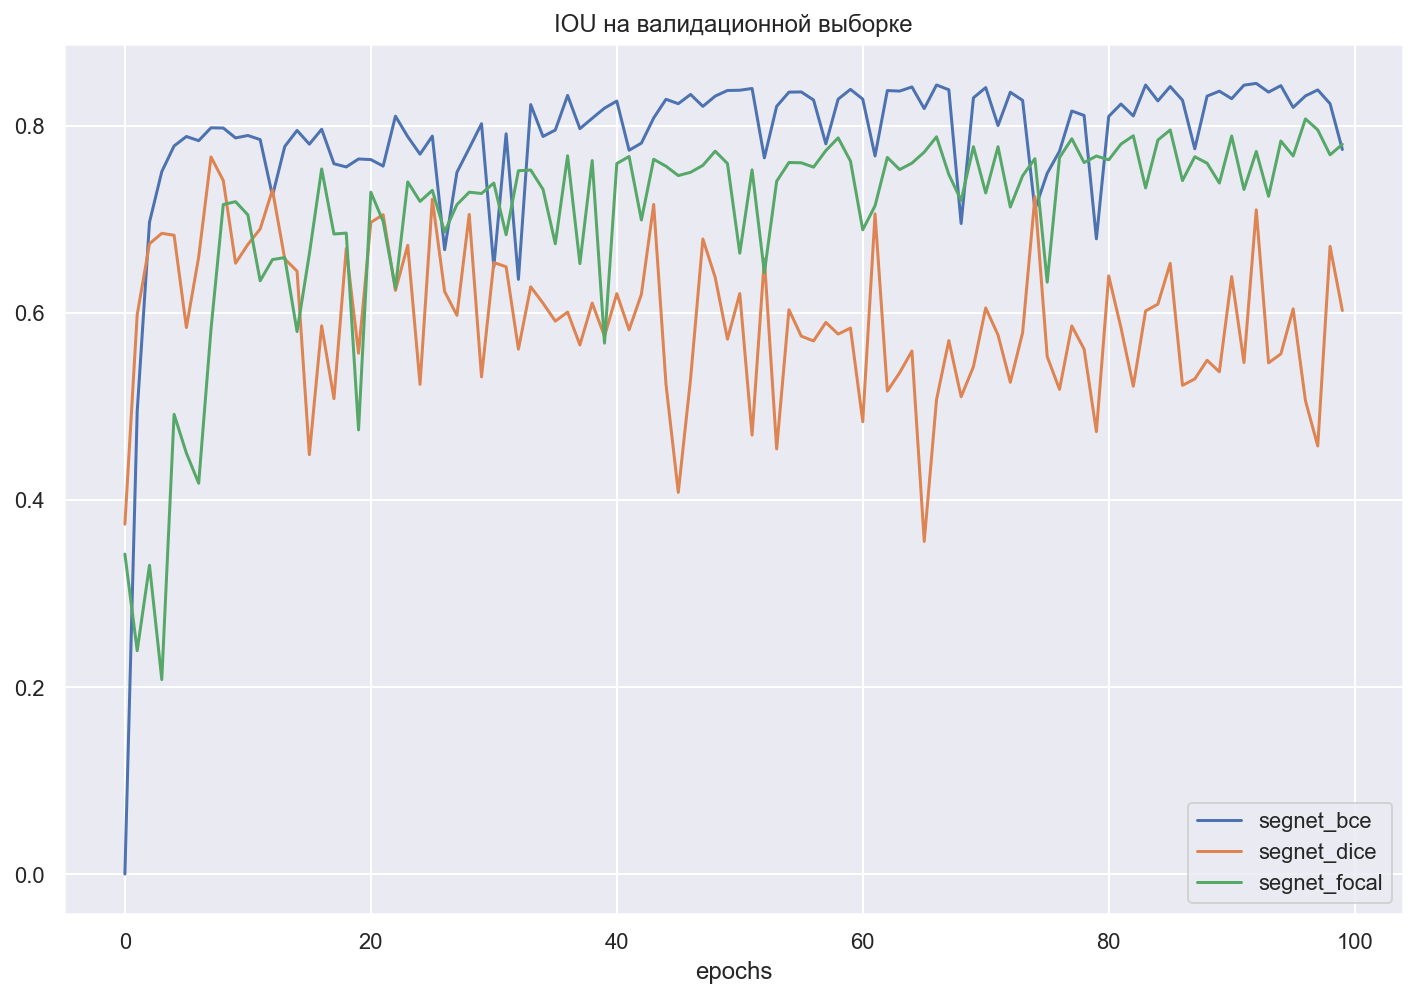

In [97]:
plot_iou(segnet_models)

In [68]:
for model in segnet_models:
    test_iou(SegNet, model)

model: segnet_bce;	IOU score on testset: 0.843
model: segnet_dice;	IOU score on testset: 0.561
model: segnet_focal;	IOU score on testset: 0.828


Видим, что на валидационной выборке лучше всего посказала себя **SegNet с BCE** лоссом, переступив порог **0.8**, на тестовой выборке заначение IOU сравнимо с моделью с focal_loss. C dice loss SegNet показала себя плохо.

### Посмотрим на UNet модели:

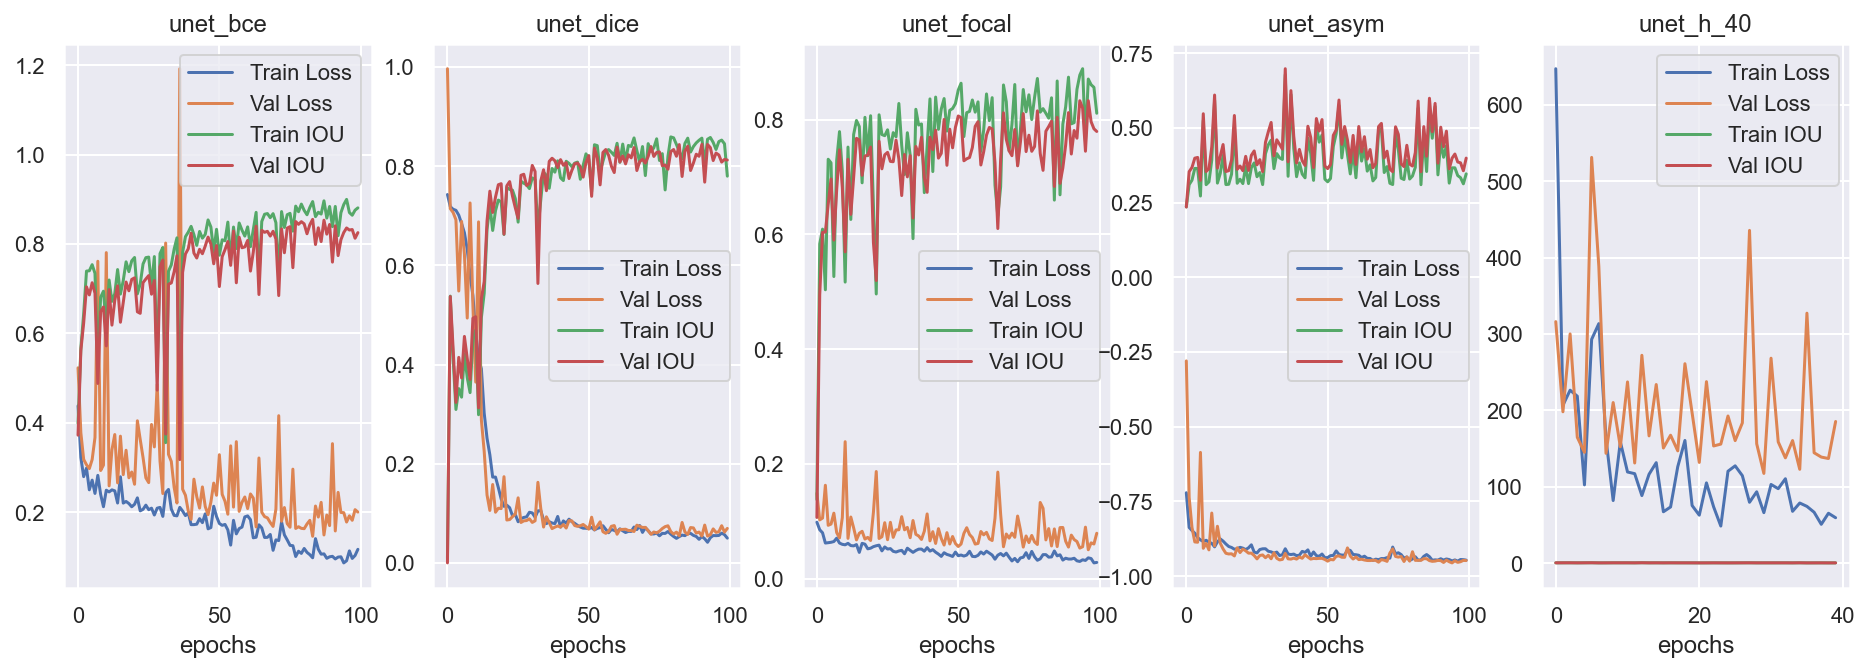

In [117]:
plot_models(unet_models)

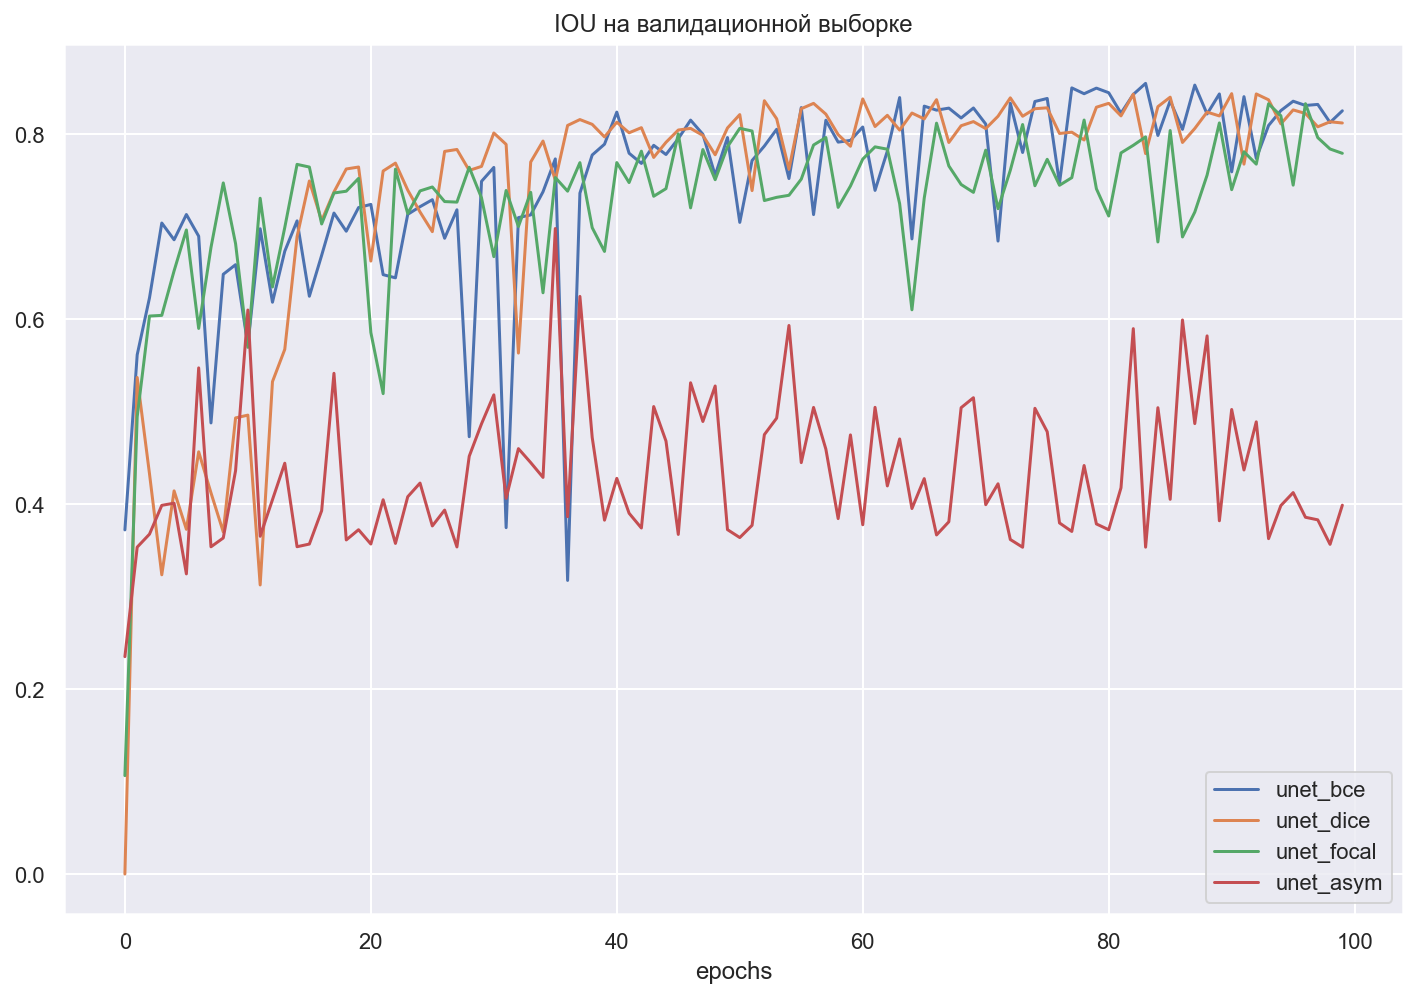

In [99]:
plot_iou(unet_models)

In [100]:
for model in unet_models:
    test_iou(UNet, model)

model: unet_bce;	IOU score on testset: 0.887
model: unet_dice;	IOU score on testset: 0.843
model: unet_focal;	IOU score on testset: 0.857
model: unet_asym;	IOU score on testset: 0.352


UNet показал сравнимые скоры IOU на **BCE, Dice, Focal** как **на валидационной ~0.8**, так и на тестовой выборке. С Asym loss Unet показала себя плохо, не превысив 0.5 IOU.

### Посмотрим на UNet2 модели:

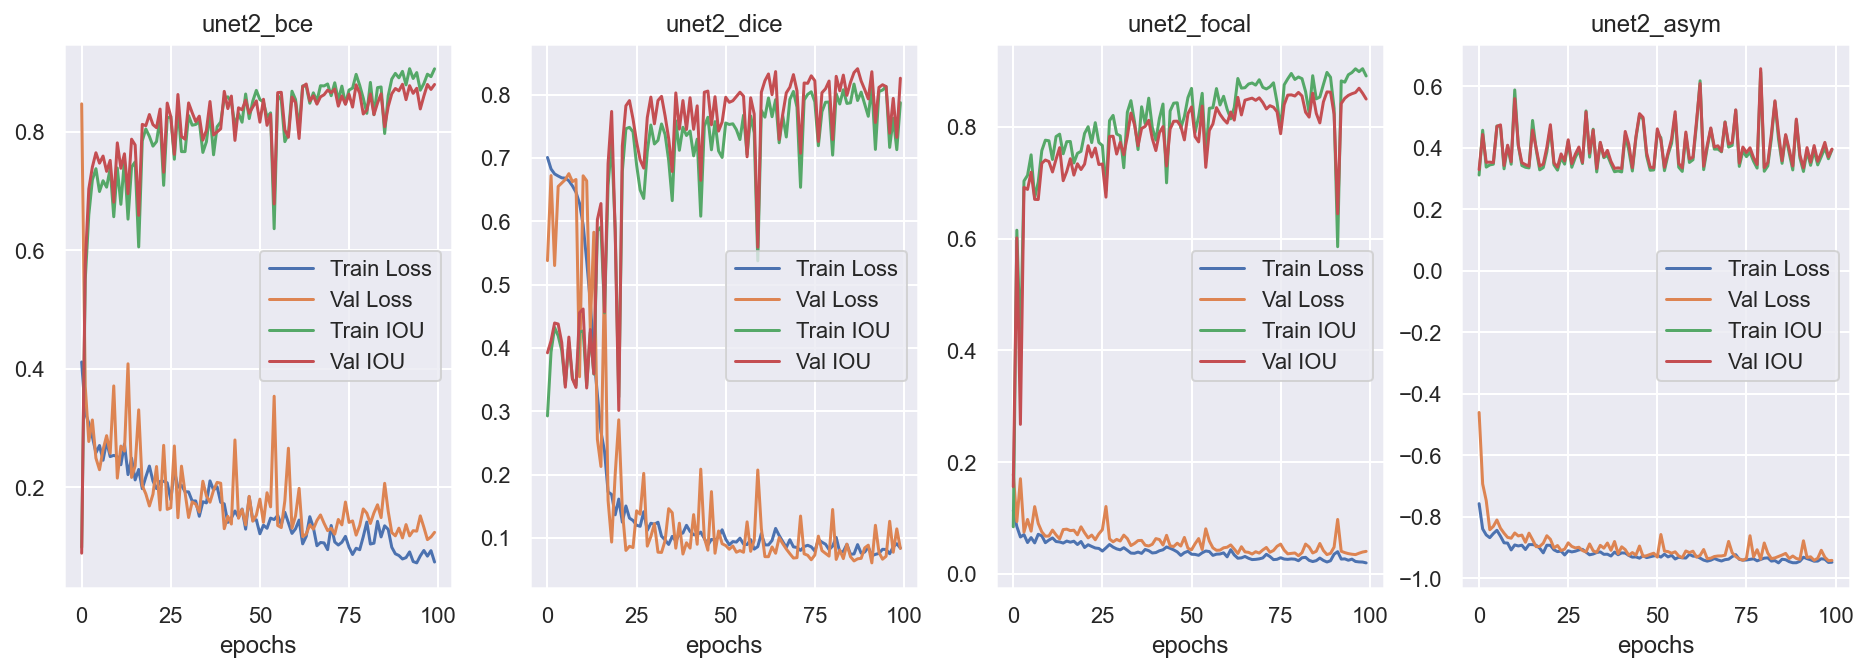

In [101]:
plot_models(unet2_models)

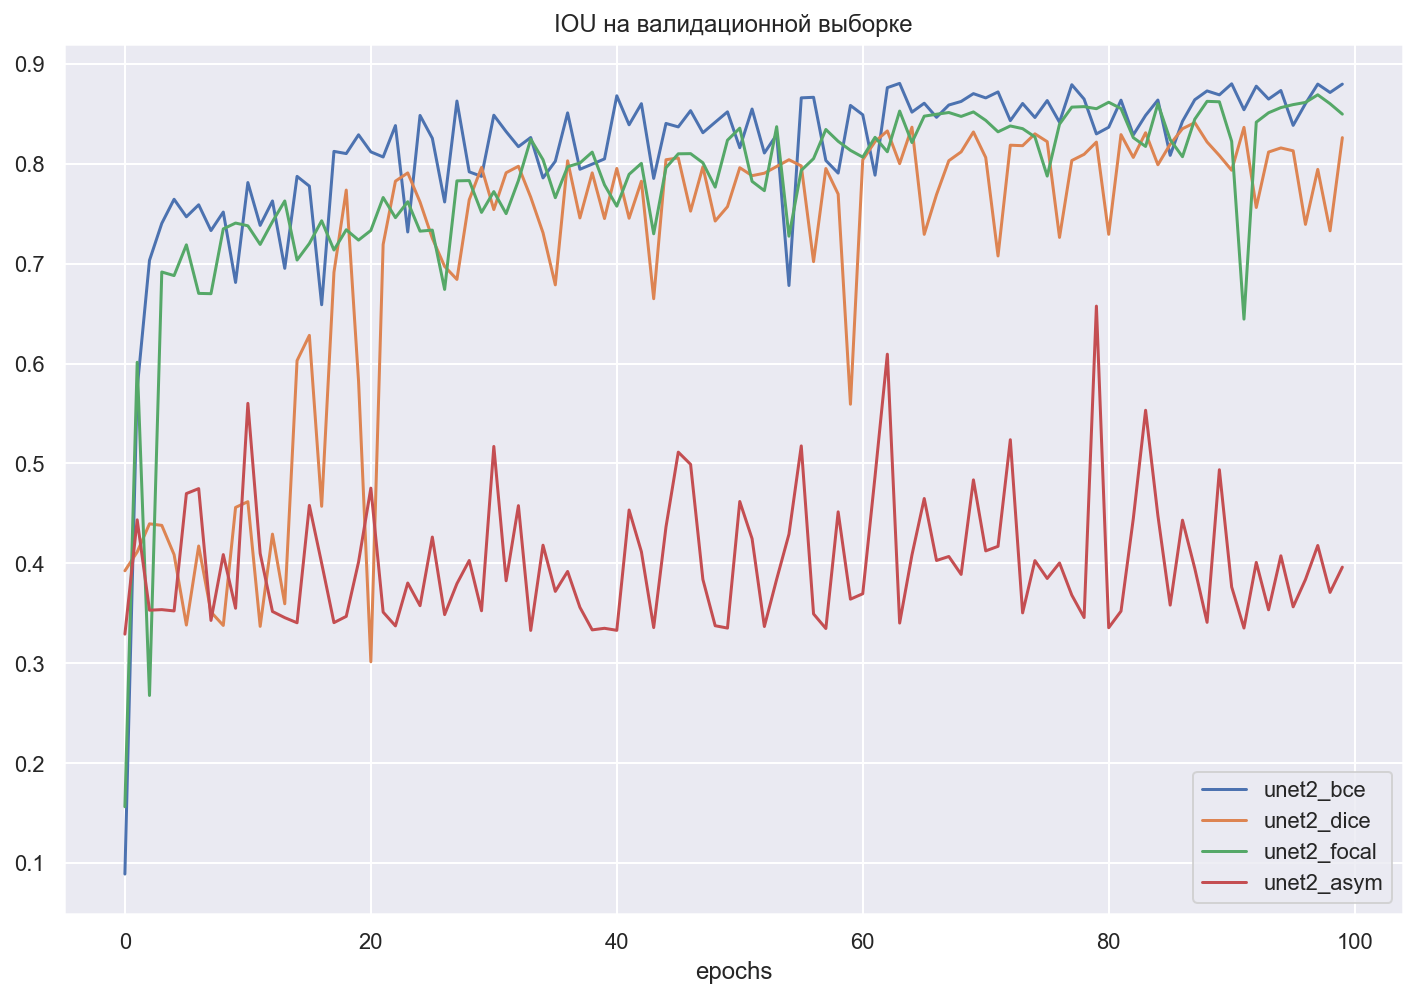

In [102]:
plot_iou(unet2_models)

In [103]:
for model in unet2_models:
    test_iou(UNet, model)

model: unet2_bce;	IOU score on testset: 0.879
model: unet2_dice;	IOU score on testset: 0.815
model: unet2_focal;	IOU score on testset: 0.877
model: unet2_asym;	IOU score on testset: 0.342


UNet2 модели показали лучшие скоры чем Unet **при BCE и Focal loss**

### Выберем модели разных архитектур с лучшими лоссами

In [104]:
best_models = ['segnet_bce', 'unet_bce', 'unet2_bce', 'unet2_focal']

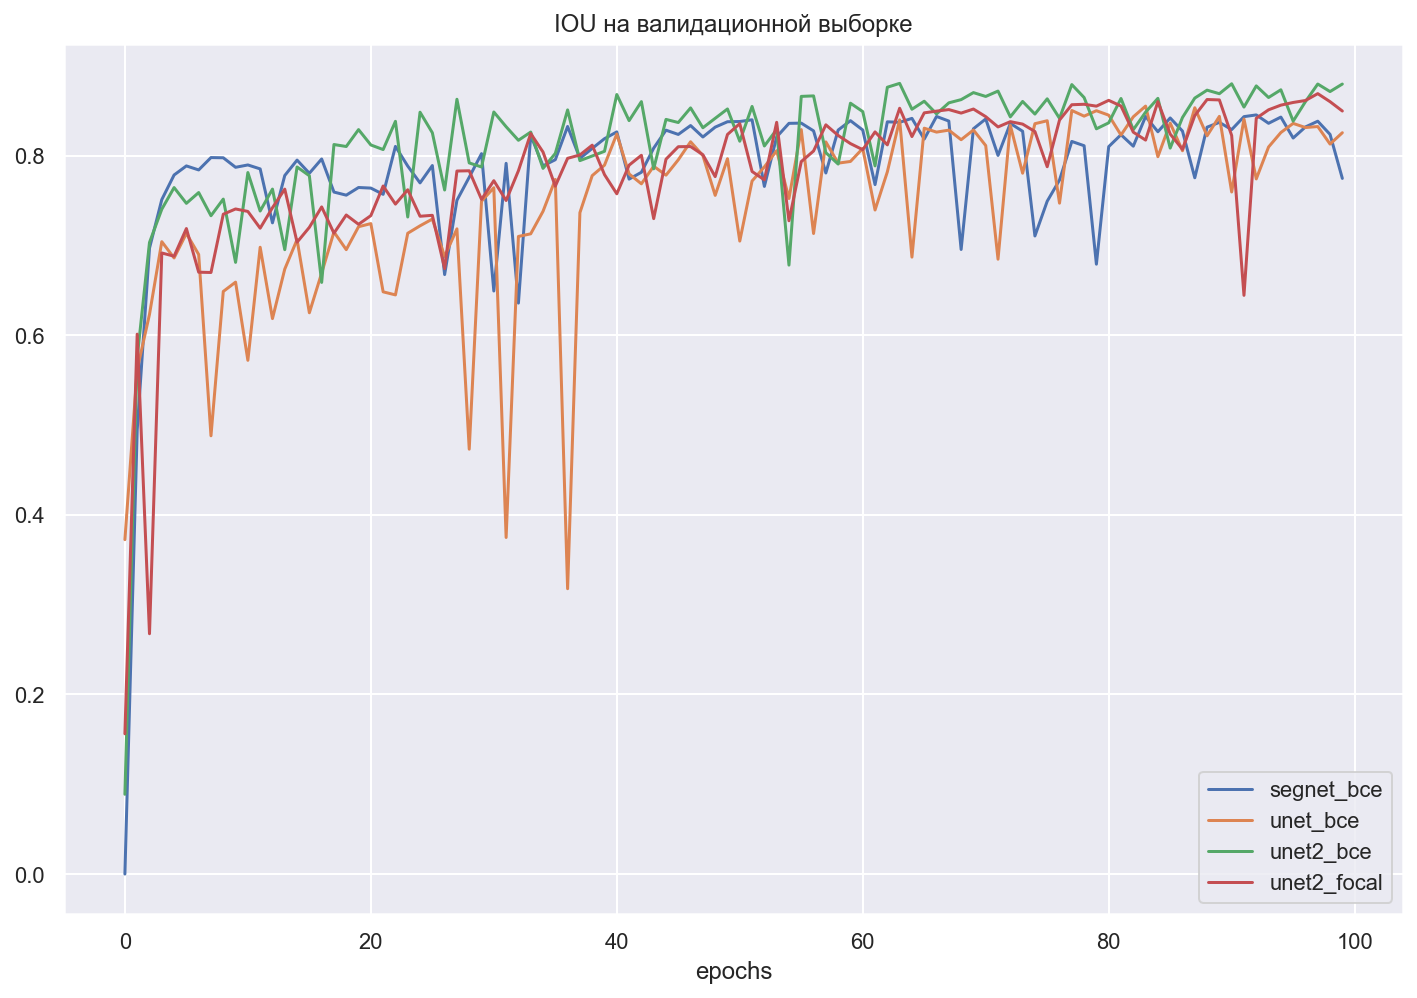

In [105]:
plot_iou(best_models)

In [113]:
test_iou(SegNet, best_models[0])
for i in range(1, 4):
    test_iou(UNet, best_models[i])

model: segnet_bce;	IOU score on testset: 0.843
model: unet_bce;	IOU score on testset: 0.887
model: unet2_bce;	IOU score on testset: 0.879
model: unet2_focal;	IOU score on testset: 0.877


Среди этих моделей лучше всего на валидационной выборке показывала себя модель **UNet2 с BCE loss**. Также она показала отличный скор IOU на тестовой выборке. Все модели были обучены на Kaggle при 100 эпохах, `batch_size=5`. Т.к признаков сильного переобучения у данной модели при 100 эпохах не наблюдается, обучим её при большем количестве.

**При 400 эпохах:**

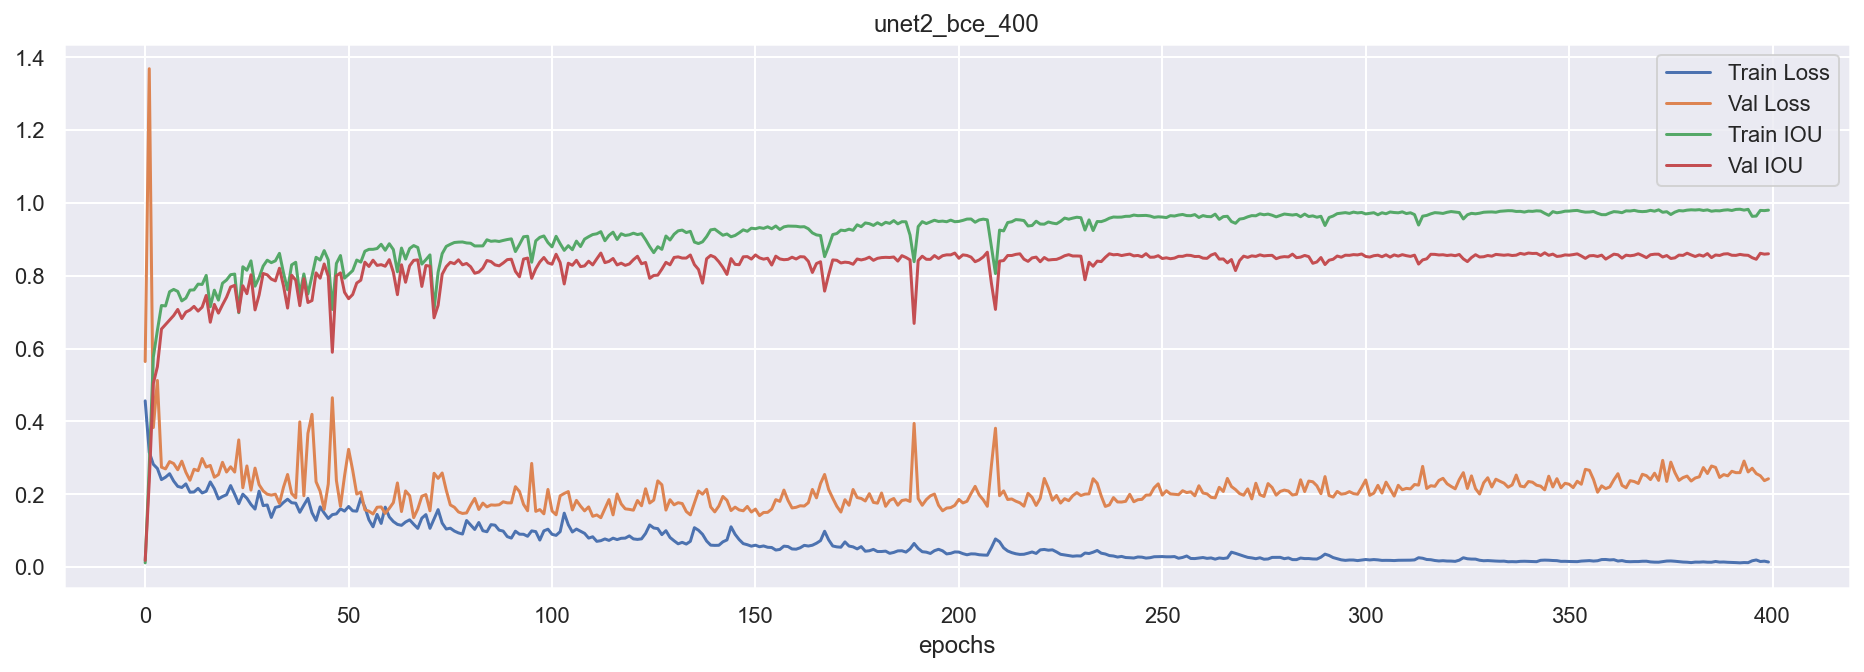

In [119]:
plot_models(['unet2_bce_400'])

Видно, что при >150 эпохах модель начинает переобучаться. Скор модели, остановленной `train_model()` на тестовой выборке:

In [123]:
test_iou(UNet, 'best_unet2_bce')

model: best_unet2_bce;	IOU score on testset: 0.917
